### SETUP INICIAL DO PROJETO

In [1]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account


# carregar o .env com as credenciais
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")


# detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"


# parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.raw_data.purchasing-purchaseorderdetail"       
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.raw_data_cleaned"


# configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


#doc: tables_to_process: lista de tabelas que serão processadas
#     output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned

In [2]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.raw_data.purchasing-purchaseorderdetail']


In [3]:
# Nome do dataset no Bigquery com os dados brutos (.csv) extraídos pelo Meltano 
dataset_id = 'raw_data'
print(dataset_id)

# Lista de tabelas do dataset raw_data no Bigquery
tables = client.list_tables('raw_data')
print("Tabelas disponíveis:")
for table in tables:
    print(table.table_id)

raw_data
Tabelas disponíveis:
humanresources-employee
person-address
person-businessentity
person-person
person-stateprovince
production-location
production-product
production-productcategory
production-productcosthistory
production-productinventory
production-productsubcategory
purchasing-purchaseorderdetail
purchasing-purchaseorderheader
purchasing-vendor
sales-creditcard
sales-customer
sales-salesorderdetail
sales-salesorderheader
sales-salesperson
sales-salesterritory
sales-store


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [4]:
# Setup inicial do df para realizar a EDA 

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [5]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")


print("Todas as tabelas foram processadas com sucesso!")

Processando tabela: desafioadventureworks-446600.raw_data.purchasing-purchaseorderdetail
Lendo os dados do BigQuery...
Tabela purchasing_purchaseorderdetail processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [6]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: purchasing_purchaseorderdetail


In [7]:
# Atribuir o df a uma variável com nome mais simples
purchasing_purchaseorderdetail = df_processados['purchasing_purchaseorderdetail']

print(f"Colunas: {purchasing_purchaseorderdetail.shape[1]}\nLinhas: {purchasing_purchaseorderdetail.shape[0]}")

Colunas: 9
Linhas: 8845


In [8]:
purchasing_purchaseorderdetail.head()

,purchaseorderid,purchaseorderdetailid,duedate,orderqty,productid,unitprice,receivedqty,rejectedqty,modifieddate
0,1,1,2011-04-30 00:00:00+00:00,4,1,50.26,3.00,0.00,2011-04-23 00:00:00+00:00
1,4001,8789,2014-03-13 00:00:00+00:00,25,707,13.09,20.00,0.00,2015-08-12 12:25:46.233000+00:00
2,4001,8790,2014-09-22 00:00:00+00:00,25,708,13.09,20.00,0.00,2015-08-12 12:25:46.313000+00:00
3,4001,8791,2014-07-02 00:00:00+00:00,300,711,13.08,20.00,0.00,2015-08-12 12:25:46.343000+00:00
4,4002,8792,2014-10-22 00:00:00+00:00,150,709,3.40,150.00,0.00,2015-08-12 12:25:46.343000+00:00


In [9]:
# Identificar duplicadas
duplicadas = purchasing_purchaseorderdetail[purchasing_purchaseorderdetail.duplicated(subset=['purchaseorderdetailid'], keep=False)]

# Verificar se existem duplicadas
if not duplicadas.empty:
    
    duplicadas_ordenadas = duplicadas.sort_values(by=['purchaseorderdetailid', 'modifieddate'])

    print("duplicadas ordenadas:")
    print(duplicadas_ordenadas)
else:
    print("Não foram encontradas duplicadas.")

Não foram encontradas duplicadas.


In [10]:
# Remover duplicadas* 
purchasing_purchaseorderdetail = purchasing_purchaseorderdetail.drop_duplicates(subset=['purchaseorderdetailid'], keep='last')

print(f"Linhas após remover duplicadas (baseando-se na última 'modifieddate'): {len(purchasing_purchaseorderdetail)}")

#bkp dos dados brutos
raw_data_bkp_2_sem_duplicadas = purchasing_purchaseorderdetail.copy()


#doc: bkp = backup (cópia)
#doc*: mantendo a última ocorrência com base em 'modifieddate', pois ela que indica a data da última modificação nos dados
#      Importante, pois se houver erro na ingestão (duplicação), mantém os dados íntegros.

Linhas após remover duplicadas (baseando-se na última 'modifieddate'): 8845


In [11]:
# Ordenar e exibir o df por 'purchaseorderdetailid'
purchasing_purchaseorderdetail = purchasing_purchaseorderdetail.sort_values(by=['purchaseorderdetailid'])

print(purchasing_purchaseorderdetail)

      purchaseorderid  purchaseorderdetailid                   duedate  orderqty  productid  unitprice  receivedqty  rejectedqty                     modifieddate
0                   1                      1 2011-04-30 00:00:00+00:00         4          1      50.26         3.00         0.00        2011-04-23 00:00:00+00:00
52                  2                      2 2011-04-30 00:00:00+00:00         3        359      45.12         3.00         0.00        2011-04-23 00:00:00+00:00
53                  2                      3 2011-04-30 00:00:00+00:00         3        360      45.58         3.00         0.00        2011-04-23 00:00:00+00:00
4188                3                      4 2011-04-30 00:00:00+00:00       550        530      16.09       550.00         0.00        2011-04-23 00:00:00+00:00
54                  4                      5 2011-04-30 00:00:00+00:00         3          4      57.03         2.00         1.00        2011-04-23 00:00:00+00:00
...               ...       

In [12]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in purchasing_purchaseorderdetail.columns:   
    missing_rows = purchasing_purchaseorderdetail[purchasing_purchaseorderdetail[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")

Coluna 'purchaseorderid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'purchaseorderid'.

Coluna 'purchaseorderdetailid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'purchaseorderdetailid'.

Coluna 'duedate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'duedate'.

Coluna 'orderqty': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'orderqty'.

Coluna 'productid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'productid'.

Coluna 'unitprice': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'unitprice'.

Coluna 'receivedqty': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'receivedqty'.

Coluna 'rejectedqty': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'rejectedqty'.

Coluna 'modifieddate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'modifieddate'.



In [13]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.

valores_unicos = purchasing_purchaseorderdetail.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)

Valores únicos incluindo NaN:
purchaseorderid          4012
purchaseorderdetailid    8845
duedate                   299
orderqty                   28
productid                 265
unitprice                 177
receivedqty                34
rejectedqty                13
modifieddate              308
dtype: int64


In [14]:
#verificar informações do df
purchasing_purchaseorderdetail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8845 entries, 0 to 51
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   purchaseorderid        8845 non-null   Int64              
 1   purchaseorderdetailid  8845 non-null   Int64              
 2   duedate                8845 non-null   datetime64[us, UTC]
 3   orderqty               8845 non-null   Int64              
 4   productid              8845 non-null   Int64              
 5   unitprice              8845 non-null   float64            
 6   receivedqty            8845 non-null   float64            
 7   rejectedqty            8845 non-null   float64            
 8   modifieddate           8845 non-null   datetime64[us, UTC]
dtypes: Int64(4), datetime64[us, UTC](2), float64(3)
memory usage: 725.6 KB


In [15]:
# Variáveis quantitativas*: estatísticas descritivas para verificar se ainda há o que ser feito antes de exportar os dados ao BigQuery

# Identificar colunas numéricas para análise de outliers
numeric_columns = ['orderqty', 'unitprice', 'receivedqty', 'rejectedqty']

# Estatísticas Descritivas das colunas numéricas*
print(purchasing_purchaseorderdetail[numeric_columns].describe())

# Cálculo de limites para outliers (IQR)**
for col in numeric_columns:
    q1 = purchasing_purchaseorderdetail[col].quantile(0.25)
    q3 = purchasing_purchaseorderdetail[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Exibir os limites
    print(f"\nColuna: {col}")
    print(f"Limite inferior: {lower_bound}, Limite superior: {upper_bound}")
    
    # Detecção e Análise de Outliers***
    outliers = purchasing_purchaseorderdetail[(purchasing_purchaseorderdetail[col] < lower_bound) | (purchasing_purchaseorderdetail[col] > upper_bound)]
    print(f"Outliers detectados ({len(outliers)}):")
    print(outliers[[col]])


#doc*: variáveis quantitativas são um tipo de dado que pode ser representado por números e medidas objetivas,
#doc*: realizar estatísticas descritivas para entender a centralidade e variação dos dados (valores médios, mínimos, máximos, etc.)
#doc**: calcular limites para identificar outliers (valores extremos que podem indicar erros ou casos excepcionais nos dados)
#doc***: verificar a existência de outliers para decidir ações como remoção, substituição ou tratamento, garantindo qualidade dos dados
#doc****: as colunas analisadas apresentam outliers: 


# Justificativa para manter os dados com outliers:
# 
# 1. Contexto de Varejo:
#    - No setor varejista, é comum lidar com grandes volumes de pedidos 
#      em eventos como promoções sazonais (ex.: Black Friday) ou 
#      compras realizadas por distribuidores e revendedores.
#
# 2. Diversidade de Produtos:
#    - Produtos premium ou exclusivos possuem preços mais elevados,
#      o que explica outliers em "unitprice".
#    - Itens com alta demanda podem justificar quantidades maiores 
#      em "orderqty" e "receivedqty".
#
# 3. Indicadores de Processo:
#    - Altos valores em "rejectedqty" podem indicar problemas reais na 
#      cadeia de suprimentos, como defeitos em lotes ou falhas no transporte,
#      sendo úteis para análises futuras de qualidade.
#
# 4. Potencial de Insights:
#    - Esses valores podem revelar padrões comportamentais de clientes,
#      sazonalidade, ou até mesmo oportunidades de negócio.
#
# 5. Preservação da Integridade:
#    - Excluir ou tratar esses valores pode distorcer análises ou eliminar
#      informações valiosas que refletem a realidade do negócio.
#
# Conclusão: Esses dados são verídicos dentro do contexto de varejo e, 
# mesmo que representem exceções, podem ser utilizados para análises mais 
# detalhadas e tomadas de decisão estratégicas.


       orderqty  unitprice  receivedqty  rejectedqty
count   8845.00    8845.00      8845.00      8845.00
mean     265.53      34.74       263.12         8.22
std      355.93      16.32       354.04        58.32
min        3.00       0.21         2.00         0.00
25%        3.00      25.42         3.00         0.00
50%       60.00      39.28        60.00         0.00
75%      550.00      45.44       550.00         0.00
max     8000.00      82.83      8000.00      1250.00

Coluna: orderqty
Limite inferior: -817.5, Limite superior: 1370.5
Outliers detectados (14):
    orderqty
19      5000
20      5000
21      5000
34      2000
35      2000
36      2000
37      1500
40      8000
41      8000
42      8000
48      6000
49      6000
50      6000
51      6000

Coluna: unitprice
Limite inferior: -4.614750000000004, Limite superior: 75.47925000000001
Outliers detectados (100):
      unitprice
4251      82.83
4252      82.83
4324      82.83
4325      82.83
4402      82.83
...         ...
7799 

In [16]:
# colunas numéricas
numeric_columns = ['orderqty', 'unitprice', 'receivedqty', 'rejectedqty']

# Calcular correlações
correlation_matrix = purchasing_purchaseorderdetail[numeric_columns].corr()

# Exibir a matriz de correlação
print(correlation_matrix)


# Análise da Matriz de Correlação
#
# 1. Correlação entre orderqty e receivedqty:
#    - Correlação: 1.00 (altamente positiva).
#    - Significado: As quantidades pedidas (orderqty) e recebidas (receivedqty) 
#      estão diretamente alinhadas, como esperado em processos normais de entrega.
#
# 2. Correlação entre orderqty e unitprice:
#    - Correlação: -0.35 (moderadamente negativa).
#    - Significado: Produtos mais caros (unitprice) tendem a ser comprados em menores 
#      quantidades (orderqty), refletindo um comportamento típico no varejo.
#
# 3. Correlação entre receivedqty e unitprice:
#    - Correlação: -0.34 (moderadamente negativa).
#    - Significado: Produtos com preços elevados também apresentam menor volume
#      de entrega, similar ao comportamento de orderqty.
#
# 4. Correlação entre orderqty e rejectedqty:
#    - Correlação: 0.13 (fraca positiva).
#    - Significado: Há uma leve tendência de que pedidos maiores tenham mais itens 
#      rejeitados, possivelmente devido a problemas logísticos em grandes volumes.
#
# 5. Correlação entre unitprice e rejectedqty:
#    - Correlação: -0.06 (quase nula).
#    - Significado: O preço unitário dos produtos não parece influenciar 
#      significativamente as rejeições (rejectedqty).
#
# 6. Correlação entre receivedqty e rejectedqty:
#    - Correlação: 0.13 (fraca positiva).
#    - Significado: Quantidades maiores recebidas têm uma leve relação com maiores
#      taxas de rejeição, o que é esperado, já que volumes grandes aumentam o risco
#      de problemas.
#
# Insights Gerais:
# - A maior correlação ocorre entre orderqty e receivedqty, confirmando alinhamento
#   entre pedidos e entregas.
# - Correlações negativas envolvendo unitprice mostram que produtos mais caros
#   são comprados e entregues em menores volumes.
# - Rejeições (rejectedqty) têm fraca correlação com outras variáveis, sugerindo
#   que podem ser influenciadas por fatores externos, como transporte ou qualidade
#   do produto.

             orderqty  unitprice  receivedqty  rejectedqty
orderqty         1.00      -0.35         1.00         0.13
unitprice       -0.35       1.00        -0.34        -0.06
receivedqty      1.00      -0.34         1.00         0.13
rejectedqty      0.13      -0.06         0.13         1.00


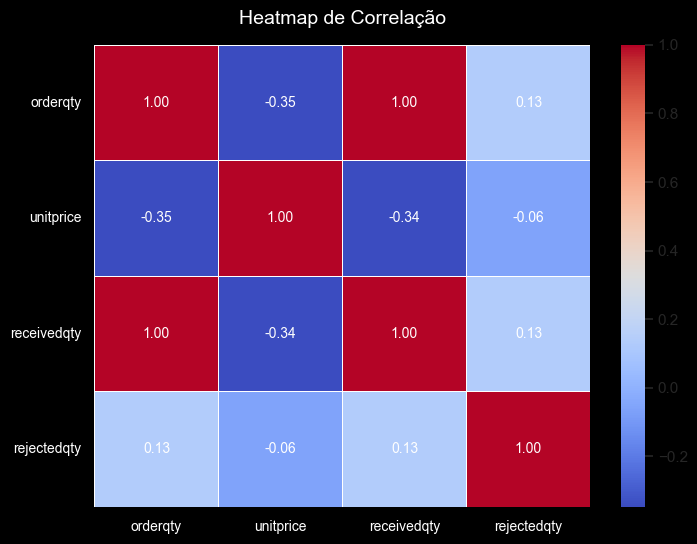

In [17]:
# Configurar o gráfico
sns.set(style='darkgrid', rc={"axes.facecolor": "black", "figure.facecolor": "black"})

numeric_columns = ['orderqty', 'unitprice', 'receivedqty', 'rejectedqty']

correlation_matrix = purchasing_purchaseorderdetail[numeric_columns].corr()

plt.figure(figsize=(8, 6))

ax = sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",
    linewidths=0.5, annot_kws={"size": 10, "color": "white"}
)

plt.title("Heatmap de Correlação", fontsize=14, color="white", pad=15)
plt.xticks(fontsize=10, color="white")
plt.yticks(fontsize=10, color="white", rotation=0)
plt.show()


# Correlação alta (vermelho escuro):

# Exemplo: orderqty e receivedqty com 1.00, indicando que as quantidades pedidas e recebidas estão fortemente alinhadas.
# Correlação moderada negativa (azul):

# Exemplo: unitprice com orderqty (-0.35), sugerindo que produtos mais caros têm menores quantidades compradas.
# Correlação baixa ou quase nula (azul claro):

# Exemplo: rejectedqty com unitprice (-0.06), mostrando que rejeições não têm relação com o preço.

In [18]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['purchasing_purchaseorderdetail'] = purchasing_purchaseorderdetail

In [19]:
# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
 
    output_table = f"{output_dataset}.{table_name}"
   
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")

Tabela purchasing_purchaseorderdetail exportada com sucesso para desafioadventureworks-446600.raw_data_cleaned.purchasing_purchaseorderdetail.
